In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, losses, backend
from sklearn.manifold import TSNE

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Process MNIST
mnist_train = (x_train > 0).reshape(60000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (x_test > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean for normalizing data
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

In [5]:
origin_1 = np.ones([mnist_train.shape[0],1])
origin_2 = np.zeros([mnistm_train.shape[0],1])
origins = np.vstack([origin_1, origin_2])
train = np.vstack([mnist_train, mnistm_train])
dummy = np.zeros([mnistm_train.shape[0],1]) - 1
labels = np.vstack([y_train.reshape([-1,1]), dummy])

# Normalizaing
train = (train-pixel_mean) / 255.

In [6]:
print("train: {}".format(train.shape))
print("label: {}".format(labels.shape))
print("origin: {}".format(origins.shape))

train: (102000, 28, 28, 3)
label: (102000, 1)
origin: (102000, 1)


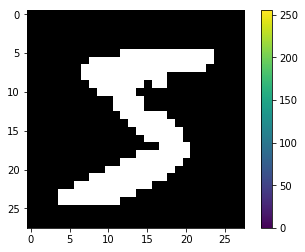

In [6]:
plt.figure()
plt.imshow(mnist_train[0])
plt.colorbar()

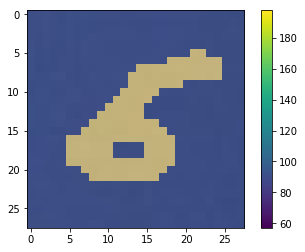

In [7]:
plt.imshow(mnistm_train[0])
plt.colorbar()

W1105 21:39:01.835825 139785461974784 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


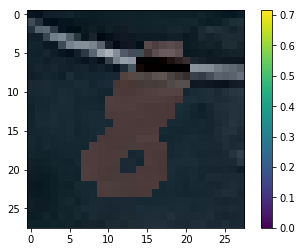

In [8]:
plt.imshow(train[90001])
plt.colorbar()

In [7]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)
    
def masking(input_pair):
    # classification
    mask = tf.dtypes.cast(backend.reshape(input_pair[:,-1], shape=[-1]), tf.bool)
    rslt = tf.boolean_mask(input_pair[:,0:-1], mask)
    return rslt

# layer = layers.Lambda(masking)
# print(layer([tf.random.uniform([4,2]),
#              [True,False,False,True]]))

In [8]:
class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        # models
        self.feature_model = self._feature_model()
        self.class_model = self._class_model()
        self.domain_model = self._domain_model()
        # losses & optimizer
        self.class_loss = losses.SparseCategoricalCrossentropy()
        self.domain_loss = losses.BinaryCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()
    
    def _feature_model(self):
        model = tf.keras.models.Sequential()
        model.add(layers.Conv2D(32, (5, 5),
                                activation='relu',
                                input_shape=(28, 28, 3),
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Conv2D(64, (5, 5),
                                activation='relu',
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        return model
    
    def _class_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(layers.Dense(100,
                               input_shape=(7 * 7 * 64,),
                               activation='relu'))
        model.add(layers.Dense(100,
                               activation='relu'))
        model.add(layers.Dense(10))
        model.add(layers.Softmax())
        model.summary()
        return model
    
    def _domain_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(GradReverse()) # reverse the gradient
        model.add(layers.Dense(100,
                               input_shape=(7 * 7 * 48,),
                               activation='relu'))
        model.add(layers.Dense(1))
        model.add(layers.Softmax())
        model.summary()
        return model
    
    @tf.function
    def train_dann(self, images, labels, origins):
        # classification
        mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
        x_able = tf.boolean_mask(images, mask)
        y_able = tf.boolean_mask(labels, mask)
        
        with tf.GradientTape() as tape:
            pred_class = self.class_model(x_able)
            loss_class = self.class_loss(y_able, pred_class)
            pred_domain = self.domain_model(images)
            loss_domain = self.domain_loss(origins, pred_domain)
            
            total_loss = loss_class + loss_domain
            
        tvars = list(set(self.class_model.trainable_variables + self.domain_model.trainable_variables))
        grads = tape.gradient(total_loss, tvars)
        self.optimizer.apply_gradients(zip(grads, tvars))

    def train_asis(self, images, labels):
        self.class_model.compile(self.optimizer, self.class_loss)
        self.class_model.fit(images, labels, epochs=1, batch_size=64)

In [9]:
dann = MNISTModel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 3136)              53696     
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 378,506
Trainable params: 378,506
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)              

In [10]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices(
    (train.astype(np.float32), labels, origins)).shuffle(102000).batch(batch_size)

In [11]:
test = (mnist_test-pixel_mean) / 255.
test2 = (mnistm_train-pixel_mean) / 255.
dann.class_model.compile(dann.optimizer, dann.class_loss)

In [13]:
for _ in range(5):
    for train_b, label_b, origin_b in train_ds:
        dann.train_dann(train_b, label_b, origin_b)
    dann.class_model.evaluate(test, y_test)    

10000/10000 [==============================] - 3s 348us/sample - loss: 0.0815


In [14]:
dann.class_model(test2[:1].astype(np.float32)).numpy()

array([[0.09516604, 0.0583063 , 0.02756915, 0.0531395 , 0.0335832 ,
        0.34947824, 0.20057   , 0.01414247, 0.09876329, 0.06928179]],
      dtype=float32)

W1119 21:53:33.010438 139986466334464 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


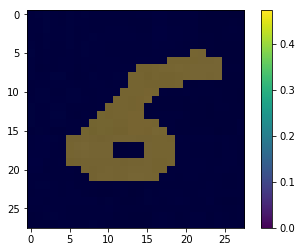

In [15]:
plt.figure()
plt.imshow(test2[0])
plt.colorbar()

In [16]:
nn = MNISTModel()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3136)              53696     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               313700    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
softmax_2 (Softmax)          (None, 10)                0         
Total params: 378,506
Trainable params: 378,506
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)              

In [17]:
mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
x_able = tf.boolean_mask(train, mask)
y_able = tf.boolean_mask(labels, mask)

In [18]:
# train nn
for _ in range(5):
    history = nn.train_asis(x_able, y_able)
    nn.class_model.evaluate(test, y_test)

10000/10000 [==============================] - 3s 347us/sample - loss: 0.0362


In [19]:
# Create a mixed dataset for TSNE visualization
num_test = 1000
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_imgs = (combined_test_imgs - pixel_mean) / 255.

y_test2 = y_test.reshape(-1,1)
combined_test_labels = np.vstack([y_test2[:num_test], y_test2[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
                                  np.tile([0., 1.], [num_test, 1])])

In [20]:
dann_emb = dann.feature_model(combined_test_imgs.astype('float32'))
tsne_d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne_d.fit_transform(dann_emb)

In [21]:
nn_emb = nn.feature_model(combined_test_imgs.astype('float32'))
tsne_n = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
nn_tsne = tsne_n.fit_transform(nn_emb)

In [22]:
n = combined_test_labels.reshape(-1).astype('str')
z = dann_tsne[:,0]
y = dann_tsne[:,1]
z2 = nn_tsne[:,0]
y2 = nn_tsne[:,1]

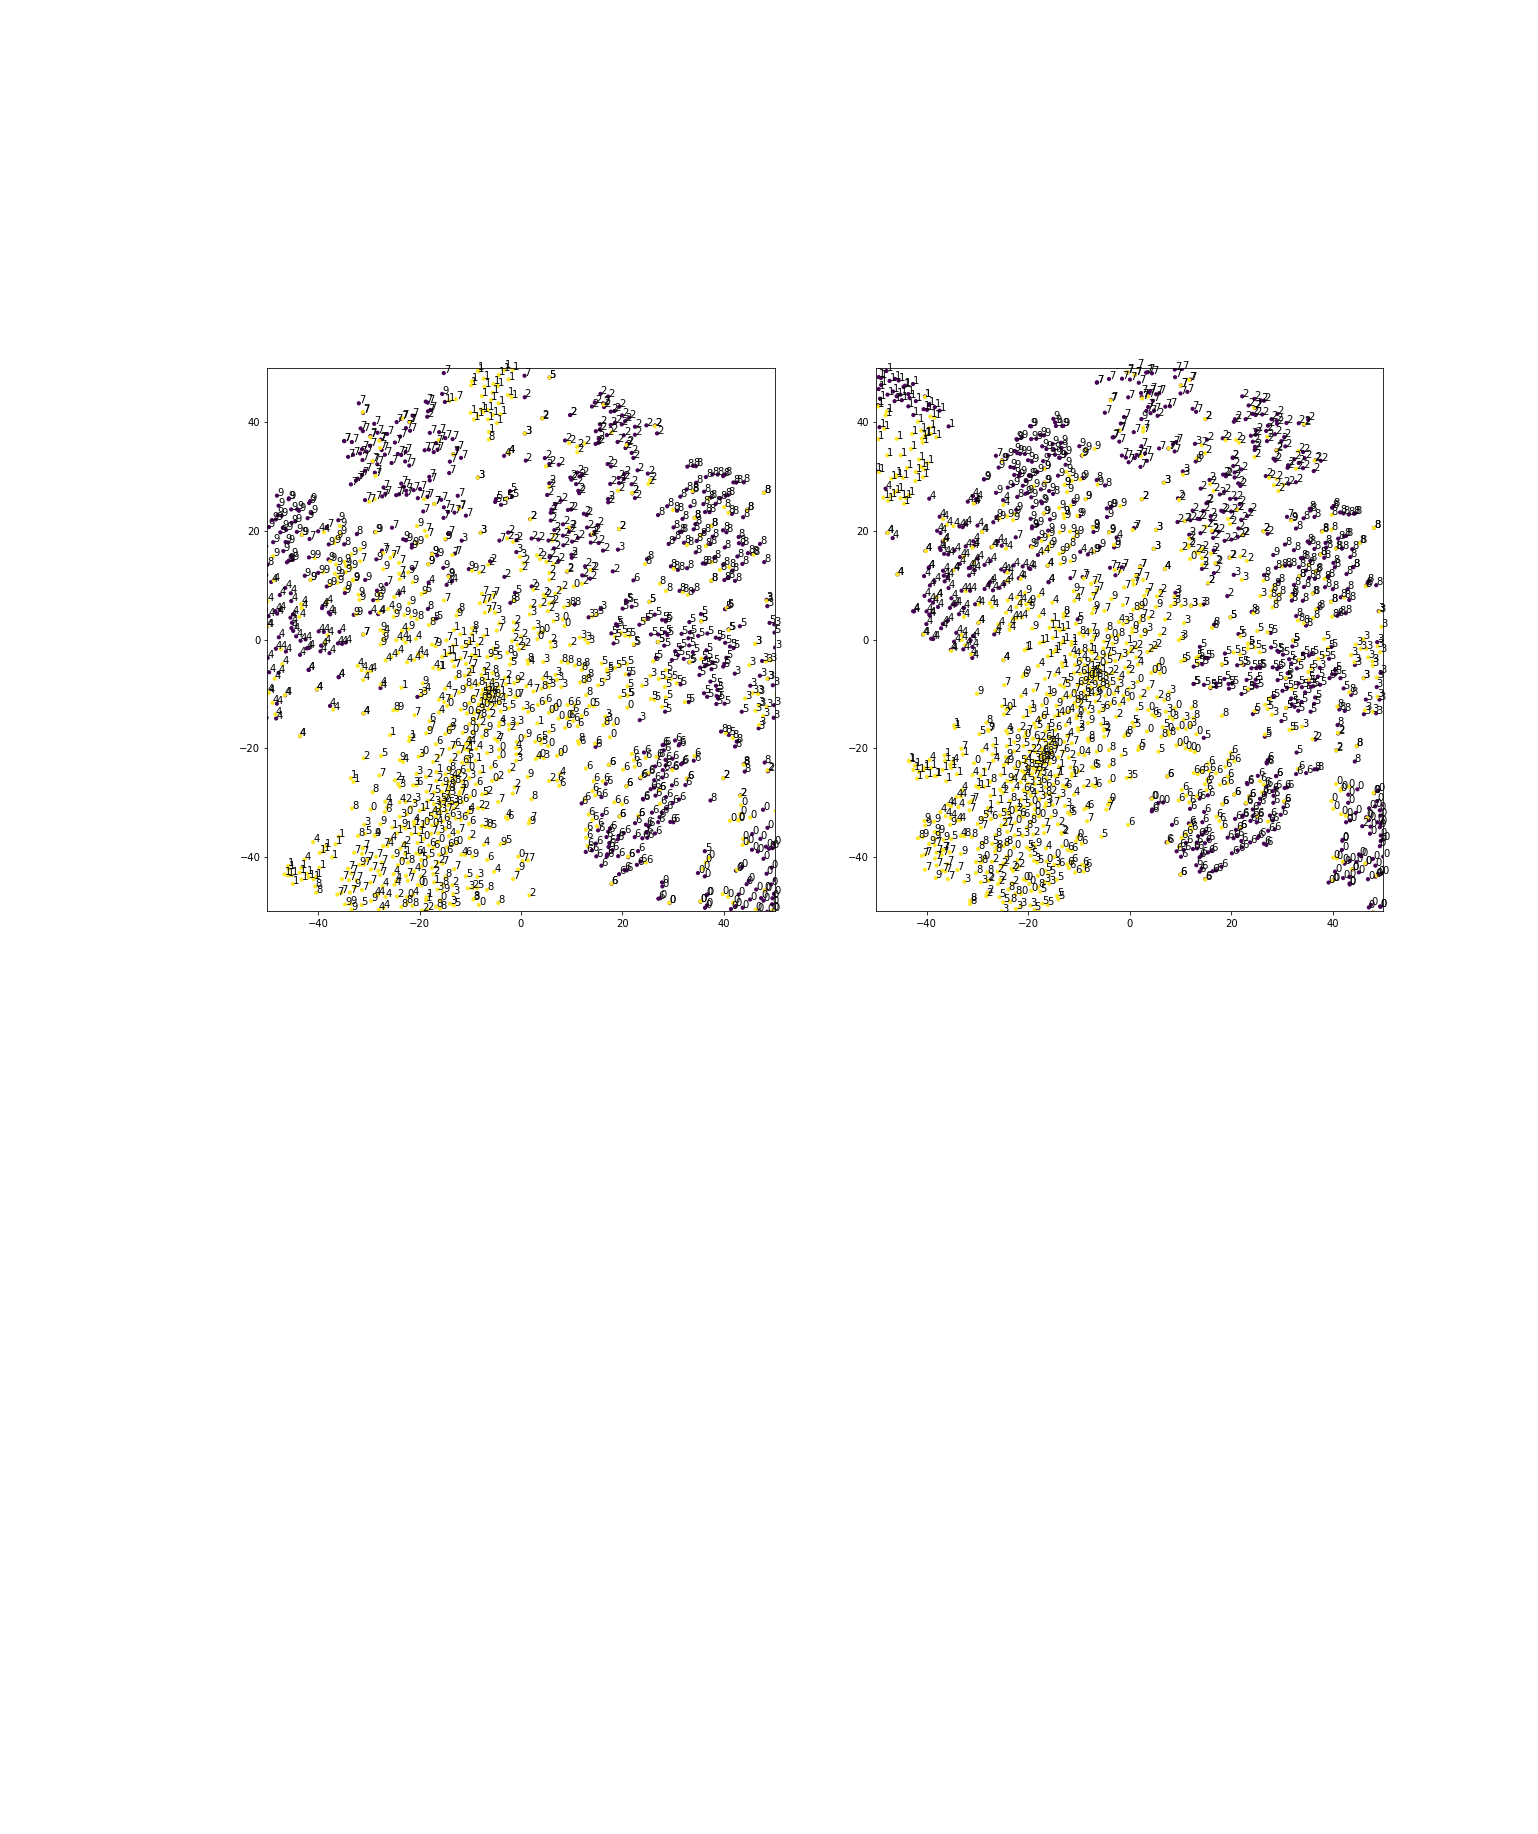

In [24]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z, y, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax1.annotate(txt, (z[i], y[i]))
ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim(-50,50)
ax2.set_ylim(-50,50)
ax2.scatter(z2, y2, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax2.annotate(txt, (z2[i], y2[i]))